Aufgabe 7

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters
from matplotlib.patches import Rectangle


image = io.imread('regionen1.png')

# RGBA → RGB, falls nötig
if image.ndim == 3 and image.shape[-1] == 4:
    image = image[..., :3]

# Graustufen → Otsu-Threshold → invertierte Binärmaske
gray = color.rgb2gray(image)
th = filters.threshold_otsu(gray)
binary_image = (gray < th).astype(np.uint8)


 Implementieren Sie die sequentielle Regionenmarkierung fur Binarbilder. Orientieren Sie
 sich bezuglich des Programmieransatzes an die Vorlesungsunterlagen (bzw. Buch Seite
 202).
 • Fur den Vektor an Kollisionen und den Vektor an Labels konnen in Python jeweils
 eine Liste von Sets angelegt werden.
 Bsp. Set in Python: a = set(); a.add(2); a.remove(2)
 Bsp. Liste in Python: l = list(); l.append(a); l.remove(a)
 • Das Eingangsbild muss zunachst in Binarform gebracht werden. (Achtung: Vorder
grund: 1 und Hintergrund: 0)

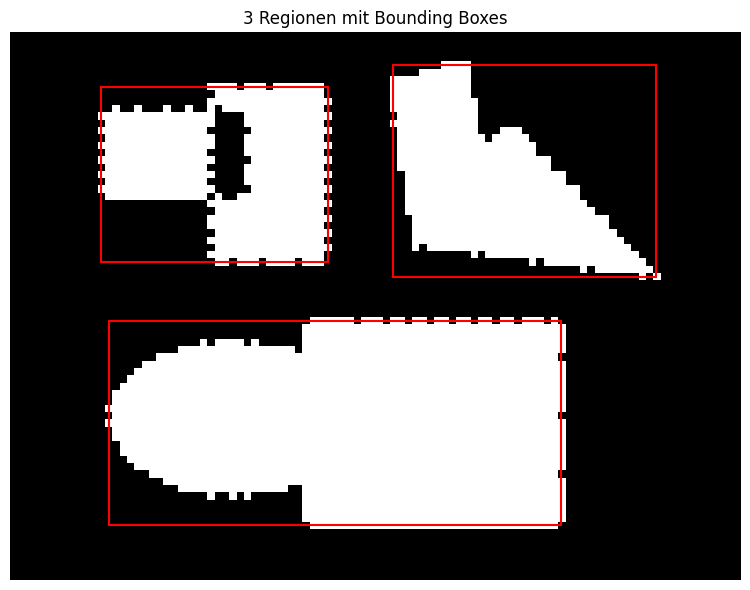

In [ ]:
def sequential_labeling(I):
    H, W = I.shape
    
    labeled = I.copy().astype(int)
    
   
    m = 2
    # Kollisionen als Menge von Paare (min, max)
    C = set()
    
    # Nachbarn (8-Nachbarschaft, nur links/oben)
    def get_neighbors(u, v):
        Ns = []
        if v > 0:
            if u > 0:        Ns.append(labeled[v-1, u-1])  # oben-links
            Ns.append(labeled[v-1, u])    # oben
            if u < W-1:     Ns.append(labeled[v-1, u+1])  # oben-rechts
        if u > 0:            Ns.append(labeled[v, u-1])  # links
        return Ns
    
    # --- Pass 1: Assign Initial Labels + Kollisionen sammeln ---
    for v in range(H):
        for u in range(W):
            if I[v, u] == 1:
                neigh = get_neighbors(u, v)
                labs = [n for n in neigh if n > 1]
                
                if not labs:
                    # keine beschrifteten Nachbarn → neues Label
                    labeled[v, u] = m
                    m += 1
                else:
                    # mindestens ein beschrifteter Nachbar
                    k = min(labs)
                    labeled[v, u] = k
                    # wenn mehrere verschiedene, Kollisionen merken
                    for other in labs:
                        if other != k:
                            C.add(tuple(sorted((other, k))))
    

    R = [ {i} for i in range(2, m) ]
    
    # Hilfsfunktion: finde das Set, das ein Label enthält
    def find_set(label):
        for s in R:
            if label in s:
                return s
        return None
    
    # Alle Kollisionen ⟨a,b⟩ abarbeiten
    for a, b in C:
        Sa = find_set(a)
        Sb = find_set(b)
        if Sa is not Sb:
            # zusammenführen
            Sa |= Sb
            R.remove(Sb)
    

    for v in range(H):
        for u in range(W):
            if labeled[v, u] > 1:
                S = find_set(labeled[v, u])
                labeled[v, u] = min(S)
    
    return labeled

# Labeling durchführen
labeled_image = sequential_labeling(binary_image)


labels = np.unique(labeled_image)
labels = labels[labels > 1] 

boxes = []
for L in labels:
    pts = np.argwhere(labeled_image == L)
    rmin, cmin = pts.min(axis=0)
    rmax, cmax = pts.max(axis=0)
    boxes.append((cmin, rmin, cmax, rmax))


fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(binary_image, cmap='gray')
for (x1, y1, x2, y2) in boxes:
    w, h = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), w, h,
                     edgecolor='red', facecolor='none', linewidth=1.5)
    ax.add_patch(rect)

ax.set_title(f"{len(boxes)} Regionen mit Bounding Boxes")
ax.axis('off')
plt.tight_layout()
plt.show()